In [1]:
import pandas as pd
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # For classification
from sklearn.ensemble import RandomForestRegressor   # For regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

In [2]:
df=pd.read_csv("GUIDE_train.csv",nrows=100000)

In [3]:
df.shape

(100000, 45)

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
null=df.isna().sum()
total_length=len(df)
per=(null/total_length)*100
per=per.sort_values(ascending=False)
per=per[per>50].index
df.drop(columns=per,inplace=True)

In [22]:
df

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,TruePositive,Ip,Related,98799,138268,27,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,31,6,3
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,FalsePositive,User,Impacted,98799,138268,360606,160396,22406,23032,22795,24887,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,FalsePositive,Url,Related,98799,138268,360606,68652,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,BenignPositive,Url,Related,98799,138268,360606,13,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,TruePositive,User,Impacted,98799,138268,360606,160396,449,592,440,479,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,549755815810,530,13621,9184,2024-06-06T20:33:18.000Z,577,650,Ransomware,BenignPositive,File,Related,98799,138268,360606,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,177035,0,3586,5,66,242,1445,10630
99996,343597384041,142,439844,1505560,2024-06-03T10:22:06.000Z,33,22,InitialAccess,FalsePositive,User,Impacted,98799,138268,360606,160396,196,168,187,220,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
99997,1185410975536,303,394,1308734,2024-06-15T09:32:31.000Z,0,0,InitialAccess,TruePositive,CloudLogonRequest,Related,98799,138268,360606,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630
99998,154618827497,1168,6386,23247,2024-06-04T01:37:44.000Z,1,1,InitialAccess,TruePositive,User,Impacted,98799,138268,360606,160396,12602,18169,12895,14864,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630


In [6]:
df["IncidentGrade"].isna().sum()

525

In [7]:
df.dropna(subset=['IncidentGrade'], inplace=True)

In [8]:
df["IncidentGrade"].value_counts()

IncidentGrade
BenignPositive    43024
TruePositive      34887
FalsePositive     21564
Name: count, dtype: int64

In [9]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['year'] = df['Timestamp'].dt.year
df['month'] = df['Timestamp'].dt.month
df['day'] = df['Timestamp'].dt.day
df['hour'] = df['Timestamp'].dt.hour
df['minute'] = df['Timestamp'].dt.minute
df['second'] = df['Timestamp'].dt.second
df.drop(columns=["Timestamp"],inplace=True)
df.drop(columns=["Id"],inplace=True)


In [11]:

benign_positive = df[df['IncidentGrade'] == 'BenignPositive']
true_positive = df[df['IncidentGrade'] == 'TruePositive']
false_positive = df[df['IncidentGrade'] == 'FalsePositive']

min_size = len(false_positive)
benign_positive_downsampled = resample(benign_positive, 
                                       replace=False, 
                                       n_samples=min_size, 
                                       random_state=42)

true_positive_downsampled = resample(true_positive, 
                                     replace=False, 
                                     n_samples=min_size, 
                                     random_state=42)

df = pd.concat([benign_positive_downsampled, 
                         true_positive_downsampled, 
                         false_positive])

df = df.sample(frac=1, random_state=42).reset_index(drop=True)



In [12]:
df.shape

(64692, 39)

In [13]:
Labelencoder=LabelEncoder()
for col in df.select_dtypes(include="object").columns:
    df[col]=Labelencoder.fit_transform(df[col])

In [14]:
df["IncidentGrade"].value_counts()


IncidentGrade
0    21564
1    21564
2    21564
Name: count, dtype: int64

In [15]:
df["City"].nunique()

726

In [16]:
x=df.drop(columns="IncidentGrade")
y=df["IncidentGrade"]
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,shuffle=True,stratify=y,test_size=0.3)

Experiment 1

In [17]:
model=LogisticRegression()
model.fit(x_train,y_train)
pred_y=model.predict(x_test)
params = model.get_params()
report_dict = classification_report(y_test, pred_y, output_dict=True)

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


EXperiment 2

In [18]:

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      6469
           1       0.88      0.87      0.88      6469
           2       0.93      0.86      0.89      6470

    accuracy                           0.88     19408
   macro avg       0.88      0.88      0.88     19408
weighted avg       0.88      0.88      0.88     19408



Experiment 3

In [19]:
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(x_train, y_train)
y_pred_xgb = xgb_clf.predict(x_test)
print(classification_report(y_test, y_pred_xgb))

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:51:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.88      0.90      0.89      6469
           1       0.88      0.90      0.89      6469
           2       0.93      0.89      0.91      6470

    accuracy                           0.90     19408
   macro avg       0.90      0.90      0.90     19408
weighted avg       0.90      0.90      0.90     19408



Experiment 4

In [20]:

import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Define your models with "chi test" in their names
models = [
    (
        "1.lo", 
        LogisticRegression(), 
        (x_train, y_train),
        (x_test, y_test)
    ),
    (
        "2.RAN", 
        RandomForestClassifier(), 
        (x_train, y_train),
        (x_test, y_test)
    ),
    (
        "3.X",
        XGBClassifier(), 
        (x_train, y_train),
        (x_test, y_test)
    )  
]

# Create a list to store classification reports
reports = []

# Fit models and generate reports
for model_name, model, train_set, test_set in models:
    x_train, y_train = train_set
    x_test, y_test = test_set
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)

# Set up MLflow
mlflow.set_experiment("new_3")
mlflow.set_tracking_uri("http://localhost:5000")

# Log models and metrics to MLflow
for i, (model_name, model, _, _) in enumerate(models):
    report = reports[i]
    
    with mlflow.start_run(run_name=model_name):        
        mlflow.log_param("model_name", model_name)
        mlflow.log_metric('accuracy', report['accuracy'])
        mlflow.log_metric('BenignPositive', report['0']['recall'])
        mlflow.log_metric('FalsePositive', report['1']['recall'])
        mlflow.log_metric('TruePositive', report['2']['recall'])
        mlflow.log_metric('f1_score_macro', report['macro avg']['f1-score'])
        
        # Log the model
        if "XGB" in model_name:
            mlflow.xgboost.log_model(model, "model")
        else:
            mlflow.sklearn.log_model(model, "model")


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2024/09/17 10:51:25 INFO mlflow.tracking.fluent: Experiment with name 'new_3' does not exist. Creating a new experiment.
2024/09/17 10:51:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/17 10:51:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run 1.lo at: http://localhost:5000/#/experiments/4917410723208746

In [21]:

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.90      0.86      6469
           1       0.88      0.87      0.88      6469
           2       0.93      0.86      0.89      6470

    accuracy                           0.88     19408
   macro avg       0.88      0.88      0.88     19408
weighted avg       0.88      0.88      0.88     19408



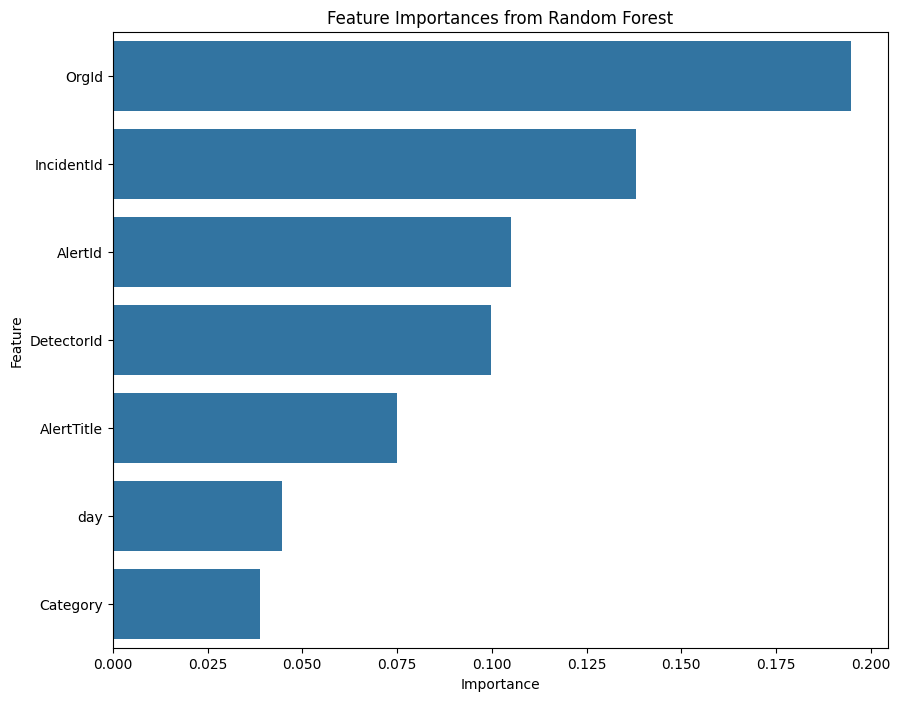

In [22]:

importances = model.feature_importances_

importances_df = pd.DataFrame({
    'Feature': x.columns,
    'Importance': importances
})

importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df.head(7))
plt.title('Feature Importances from Random Forest')
plt.show()


In [23]:
n_df=df[["OrgId","IncidentId","AlertId","AlertTitle","day","Category","DetectorId","IncidentGrade"]]

In [24]:
n_df["IncidentGrade"].value_counts()

IncidentGrade
0    21564
1    21564
2    21564
Name: count, dtype: int64

In [25]:
def split(df):
    x=df.drop(columns=["IncidentGrade"])
    y=df["IncidentGrade"]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42,shuffle=True, stratify=y)
    return x,y,x_train, x_test, y_train, y_test

In [26]:
x, y, x_train, x_test, y_train, y_test = split(n_df)

In [27]:
x, y, x_train, x_test, y_train, y_test = split(n_df)
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Define your models with "chi test" in their names
models = [
    (
        "r.log", 
        LogisticRegression(), 
        (x_train, y_train),
        (x_test, y_test)
    ),
    (
        "r.RAN", 
        RandomForestClassifier(), 
        (x_train, y_train),
        (x_test, y_test)
    ),
    (
        "r.XGB",
        XGBClassifier(), 
        (x_train, y_train),
        (x_test, y_test)
    )  
]

# Create a list to store classification reports
reports = []

# Fit models and generate reports
for model_name, model, train_set, test_set in models:
    x_train, y_train = train_set
    x_test, y_test = test_set
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    reports.append(report)

# Set up MLflow
mlflow.set_experiment("new_4")
mlflow.set_tracking_uri("http://localhost:5000")

# Log models and metrics to MLflow
for i, (model_name, model, _, _) in enumerate(models):
    report = reports[i]
    
    with mlflow.start_run(run_name=model_name):        
        mlflow.log_param("model_name", model_name)
        mlflow.log_metric('accuracy', report['accuracy'])
        mlflow.log_metric('BenignPositive', report['0']['recall'])
        mlflow.log_metric('FalsePositive', report['1']['recall'])
        mlflow.log_metric('TruePositive', report['2']['recall'])
        mlflow.log_metric('f1_score_macro', report['macro avg']['f1-score'])
        
        # Log the model
        if "XGB" in model_name:
            mlflow.xgboost.log_model(model, "model")
        else:
            mlflow.sklearn.log_model(model, "model")


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2024/09/17 10:52:17 INFO mlflow.tracking.fluent: Experiment with name 'new_4' does not exist. Creating a new experiment.
2024/09/17 10:52:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/17 10:52:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run r.log at: http://localhost:5000/#/experiments/865368380888824

In [28]:
reports

[{'0': {'precision': 0.4888316151202749,
   'recall': 0.2638534662647809,
   'f1-score': 0.3427194699593435,
   'support': 4313.0},
  '1': {'precision': 0.407061751438793,
   'recall': 0.6067702295386043,
   'f1-score': 0.4872463228449078,
   'support': 4313.0},
  '2': {'precision': 0.6329507412721186,
   'recall': 0.6137259448179921,
   'f1-score': 0.6231901118304886,
   'support': 4313.0},
  'accuracy': 0.49478321354045907,
  'macro avg': {'precision': 0.5096147026103955,
   'recall': 0.49478321354045907,
   'f1-score': 0.48438530154491327,
   'support': 12939.0},
  'weighted avg': {'precision': 0.5096147026103955,
   'recall': 0.49478321354045907,
   'f1-score': 0.4843853015449133,
   'support': 12939.0}},
 {'0': {'precision': 0.9031963470319635,
   'recall': 0.917226988175284,
   'f1-score': 0.9101575980674106,
   'support': 4313.0},
  '1': {'precision': 0.9127423822714681,
   'recall': 0.9167632738233248,
   'f1-score': 0.9147484094852516,
   'support': 4313.0},
  '2': {'precision

In [29]:
x, y, x_train, x_test, y_train, y_test = split(n_df)
model=RandomForestClassifier()
random=model.fit(x_train,y_train)

y_pred = random.predict(x_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      4313
           1       0.91      0.92      0.92      4313
           2       0.94      0.93      0.93      4313

    accuracy                           0.92     12939
   macro avg       0.92      0.92      0.92     12939
weighted avg       0.92      0.92      0.92     12939



train the test the model given test csv

In [30]:
df1=pd.read_csv("GUIDE_test.csv",nrows=10000)
null=df1.isna().sum()
total_length=len(df1)
per=(null/total_length)*100
per=per.sort_values(ascending=False)
per=per[per>50].index
df1.drop(columns=per,inplace=True)
df1.drop(columns="Usage",inplace=True)
df1.dropna(subset=["IncidentGrade"])

df1['Timestamp'] = pd.to_datetime(df1['Timestamp'])
df1['year'] = df1['Timestamp'].dt.year
df1['month'] = df1['Timestamp'].dt.month
df1['day'] = df1['Timestamp'].dt.day
df1['hour'] = df1['Timestamp'].dt.hour
df1['minute'] = df1['Timestamp'].dt.minute
df1['second'] = df1['Timestamp'].dt.second
df1.drop(columns=["Timestamp"],inplace=True)
df1.drop(columns=["Id"],inplace=True)
Labelencoder=LabelEncoder()
for col in df1.select_dtypes(include="object").columns:
    df1[col]=Labelencoder.fit_transform(df1[col])

n_df=df1[["OrgId","IncidentId","AlertId","AlertTitle","day","Category","DetectorId","IncidentGrade"]]
x_test=n_df.drop(columns="IncidentGrade")
y_test=n_df["IncidentGrade"]
y_pred = random.predict(x_test)

print(classification_report(y_test,y_pred))



              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4192
           1       0.79      0.87      0.83      2167
           2       0.92      0.88      0.90      3641

    accuracy                           0.88     10000
   macro avg       0.87      0.88      0.87     10000
weighted avg       0.88      0.88      0.88     10000



hyper parameter with randaom forest

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
x, y, x_train, x_test, y_train, y_test = split(n_df)
# Define the parameter grid
param_grid = {
    'n_estimators': [300],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
}                                    
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(x_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(x_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Score: 0.8702500000000001
              precision    recall  f1-score   support

           0       0.82      0.94      0.87       838
           1       0.88      0.75      0.81       434
           2       0.92      0.86      0.89       728

    accuracy                           0.87      2000
   macro avg       0.87      0.85      0.86      2000
weighted avg       0.87      0.87      0.87      2000

[[784  22  32]
 [ 88 324  22]
 [ 83  21 624]]


its perform poor in train but perform good in train test

In [32]:
t_df=df1[["OrgId","IncidentId","AlertId","AlertTitle","day","Category","DetectorId","IncidentGrade"]]
x_test=t_df.drop(columns="IncidentGrade")
y_test=t_df["IncidentGrade"]
y_pred = best_rf.predict(x_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      4192
           1       0.98      0.95      0.96      2167
           2       0.98      0.97      0.98      3641

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

[[4138   22   32]
 [  88 2057   22]
 [  83   21 3537]]


In [ ]:
model1=[0.87,0.87,0.89,0.86,0.86]
model2=[0.97,0.96,0.98,0.97,0.97]


In [ ]:
import numpy as np
from scipy.stats import chi2_contingency

# Confusion matrix for Model 1
rf_confusion_matrix = np.array([[3656, 330, 206],
                                [182, 1892, 93],
                                [246, 183, 3212]])

xgb_confusion_matrix = np.array([[3656, 336, 200],
                                 [158, 1917, 92],
                                 [201, 160, 3280]])

# Perform chi-square test for Model 1
chi2_stat1, p_value1, dof1, expected1 = chi2_contingency(rf_confusion_matrix)

# Perform chi-square test for Model 2
chi2_stat2, p_value2, dof2, expected2 = chi2_contingency(xgb_confusion_matrix)

# Print results
print(f"Model 1 - Chi-Square Statistic: {chi2_stat1}, P-Value: {p_value1}")
print(f"Model 2 - Chi-Square Statistic: {chi2_stat2}, P-Value: {p_value2}")

# Determine the better model based on p-values
alpha = 0.05
if p_value1 < alpha:
    print("Model 1 shows significant differences in prediction (more consistent).")
else:
    print("Model 1 does not show significant differences in prediction (less consistent).")

if p_value2 < alpha:
    print("Model 2 shows significant differences in prediction (more consistent).")
else:
    print("Model 2 does not show significant differences in prediction (less consistent).")
